In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Concatenate, BatchNormalization, Activation, Conv1D, Flatten
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from CyclicLR import CyclicLR

Using TensorFlow backend.


In [3]:
def auc(y_true, y_pred):
    f1 = lambda: tf.constant(0, dtype=tf.float64)
    f2 = lambda: tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    
    r = tf.case([(tf.equal(tf.reduce_sum(y_true), tf.constant(0, dtype=tf.float32)), f1),
                 (tf.equal(tf.reduce_sum(tf.subtract(tf.ones_like(y_true), y_true)), tf.constant(0, dtype=tf.float32)), f1)
                ], default=f2)
    return r

In [4]:
df_train = pd.read_csv('train_with_counts.csv')
df_test = pd.read_csv('test_with_counts.csv').drop(columns=['ID_code', 'target'])
y = df_train['target'].values

In [5]:
df_test.shape

(200000, 400)

In [6]:
df_train_X = df_train.drop(columns=['ID_code', 'target'])
df_train_X_normalized = (df_train_X - df_train_X.mean(axis=0))/df_train_X.std(axis=0)
df_test_X_normalized = (df_test - df_test.mean(axis=0))/df_test.std(axis=0)

In [7]:
N_vars = 200

def get_data(trn_idx, val_idx, N_vars = 200):
    X_train = []
    X_val = []
    for i in range(N_vars):
        X_train.append(df_train_X_normalized[[f'var_{i}', f'var_{i}_FE']].values[trn_idx])
        X_val.append(df_train_X_normalized[[f'var_{i}', f'var_{i}_FE']].values[val_idx])
    return X_train, X_val

def get_test_data(N_vars = 200):
    X_test = []
    for i in range(N_vars):
        X_test.append(df_test_X_normalized[[f'var_{i}', f'var_{i}_FE']].values)
    return X_test

In [8]:
def get_model():
    denseOuts = []
    inputs = []
    for i in range(N_vars):
        inp = Input((2,))
        inputs.append(inp)
        dense_out = Dense(1000)(inp)
        # dense_1000_out = Activation('relu')(dense_out)
        # dense_1000_out = LeakyReLU()(dense_out)
        denseOuts.append(dense_out)
    x = Concatenate()(denseOuts)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, out)
    return model

In [9]:
# leaky
# def get_model():
#     denseOuts = []
#     inputs = []
#     for i in range(N_vars):
#         inp = Input((2,))
#         inputs.append(inp)
#         dense_out = Dense(1000)(inp)
#         # dense_1000_out = Activation('relu')(dense_out)
#         # dense_1000_out = LeakyReLU()(dense_out)
#         denseOuts.append(dense_out)
#     x = Concatenate()(denseOuts)
#     # x = BatchNormalization()(x)
#     x = LeakyReLU()(x)
#     out = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs, out)
#     return model

In [10]:
# def get_model():
#     model = Sequential()
#     model.add(Conv1D(200, kernel_size=2, strides=2, padding='valid', activation='relu', input_shape=(400, 1)))
#     # model.add(Dense(1, activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(1, activation='sigmoid'))
#     return model

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
full_val_preds = np.zeros((len(df_train_X_normalized), 1))
model = get_model()
test_predictions = 0
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train_X_normalized, y)):
    print('###############################################')
    print(f'##################Fold {fold}#######################')
    print('###############################################')
    X_train, X_val = get_data(trn_idx, val_idx)
    model.load_weights(f'big_NN_fold_{fold}_lr_5e-05.hdf5')
    full_val_preds[val_idx] = model.predict(X_val, verbose=1)
    print(roc_auc_score(y[val_idx], full_val_preds[val_idx]))
    X_test = get_test_data()
    test_predictions = test_predictions + model.predict(X_test, verbose=1)/5

###############################################
##################Fold 0#######################
###############################################
40001/40001 [==============================] - 9s 230us/step
0.9187351021773377
200000/200000 [==============================] - 43s 217us/step
###############################################
##################Fold 1#######################
###############################################
40001/40001 [==============================] - 9s 217us/step
0.9136588533942942
 98304/200000 [=============>................] - ETA: 22s

In [11]:
# Full Roc auc
roc_auc_score(y, full_val_preds)
# big_NN_fold relu 0.9177075727563082
# big_NN_2_fold leaky_relu

0.9177075727563082

In [30]:
from matplotlib import pyplot as plt

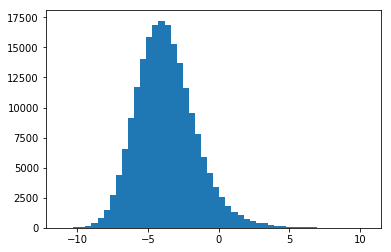

In [32]:
_ = plt.hist(np.log(test_predictions/(1-test_predictions)), 50)

In [33]:
train_path = '../../datasets/santander_customer_transaction_prediction/train.csv'
test_path = '../../datasets/santander_customer_transaction_prediction/test.csv'
def save_submit_file(predictions, filename, message, test_filename=test_path, index_column='ID_code', target_column = 'target'):
    df_test_submit = pd.read_csv(test_filename).set_index(index_column)
    df_test_submit[target_column] = predictions
    df_test_submit[[target_column]].to_csv(filename)
    return "kaggle competitions submit -c santander-customer-transaction-prediction -f {} -m '{}'".format(filename, message)

In [34]:
save_submit_file(test_predictions, 'submit_Big_NN.csv', 'big NN with magic')

"kaggle competitions submit -c santander-customer-transaction-prediction -f submit_Big_NN.csv -m 'big NN with magic'"

In [35]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f submit_Big_NN.csv -m 'big NN with magic'

100%|███████████████████████████████████████| 4.44M/4.44M [00:06<00:00, 709kB/s]
Successfully submitted to Santander Customer Transaction Prediction